## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Насыбуллин А. А.|
|---------|--------|
| Группа  | М8О-107М-20 VR/AR & ИИ|

Для скачивания датасетов можно Использовать `wget` или `curl`, либо скачать вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

### Подлючение модулей и библиотек

In [22]:
import pickle
import numpy as np
import pandas as pd
from time import time

%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib import gridspec

from sklearn.model_selection import train_test_split

## Классы для работы с нейронной сетью

### Класс нейросети

In [2]:
class NeuralNetwork:
  # конструктор
  def __init__(self, layers: [] = []):
    self.layers = layers
  
  # добавление слоя
  def add(self, layer):
    self.layers.append(layer)
  
  # прямой ход: вычисление результа работы нейросети (проход по всем слоям от первого до последнего)
  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x
  
  # обратное распространение ошибки (проход с последнего слоя к первому)
  def backward(self, z):
    for layer in self.layers[::-1]:
      z = layer.backward(z)
    return z
  
  # обновление весов для слоев, имеющих данный функционал
  def update(self, learning_rate: float):
    for layer in self.layers:
      layer.update(learning_rate)

### Класс слоя нейросети

In [3]:
# класс слоя нейросети
class NeuralNetworkLayer:
  def __init__(self, n_inputs:int, n_outputs: int, activation_func):
    self.activation_func = activation_func
    self.weights = np.random.normal(0, 1.0 / np.sqrt(n_inputs), (n_outputs, n_inputs))
    self.bias = np.zeros((1, n_outputs))
    self.d_weights = np.zeros_like(self.weights)
    self.d_bias = np.zeros_like(self.bias)

  # вычисление результата работы слоя
  def forward(self, x):
    self.x = x
    pred = np.dot(x, self.weights.T) + self.bias
    outputs = self.activation_func.forward(pred)
    return outputs
  
  # обратное распространение ошибки
  def backward(self, dz):
    dz = self.activation_func.backward(dz)
    dx = np.dot(dz, self.weights)
    d_weights = np.dot(dz.T, self.x)
    d_bias = dz.sum(axis=0)
    self.d_weights = d_weights
    self.d_bias = d_bias
    return dx

  # обновление весов
  def update(self, learning_rate: float):
    self.weights -= learning_rate * self.d_weights
    self.bias -= learning_rate * self.d_bias

### Класс функций активации

In [4]:
class ActivationFunction:
  def __init__(self, func: str='softmax'):
    self.func = func
    self.__set_forward__(func)
    self.__set_backward__(func)

  # вычисление результата работы слоя
  def forward(self, z):
    self.forward(self, z)
  
  # обратное распространение ошибки
  def backward(self, dp):
    self.backward(self, dp)
      
  def __set_forward__(self, func):
    if self.func=='softmax':
      self.forward = self.__softmax_forward__
    elif self.func == 'tanh':
      self.forward = self.__tanh_forward__
    else:
      self.forward = self.__softmax_forward__
        
  def __set_backward__(self, func):
    if self.func=='softmax':
      self.backward = self.__softmax_backward__
    elif self.func == 'tanh':
      self.backward = self.__tanh_backward__
    else:
      self.backward = self.__softmax_backward__

  def __softmax_backward__(self, dp):
    p = self.forward(self.softmax_z)
    pdp = p * dp
    result = pdp - p * pdp.sum(axis=1, keepdims=True)
    return result

  def __softmax_forward__(self, z):
    self.softmax_z = z
    zmax = z.max(axis=1, keepdims=True)
    expz = np.exp(z - zmax)
    Z = expz.sum(axis=1, keepdims=True)
    probabilities = expz / Z
    return probabilities

  def __tanh_forward__(self, z):
    y = np.tanh(z)
    self.tanh_y = y
    return y
  
  def __tanh_backward__(self, dy):
    return (1.0 - self.tanh_y**2) * dy

### Класс функций потерь

In [5]:
class LossFunction:
  def __init__(self, func: str='cross-entropy'):
    self.func = func
    self.__set_forward__(func)
    self.__set_backward__(func)

  # вычисление результата работы слоя
  def forward(self, p, y):
    self.forward(self, p, y)
  
  # обратное распространение ошибки
  def backward(self, loss):
    self.backward(self, loss)
      
  def __set_forward__(self, func):
    if self.func == 'cross-entropy':
      self.forward = self.__cross_entropy_forward__
    else:
      self.forward = self.__cross_entropy_forward__
        
  def __set_backward__(self, func):
    if self.func == 'cross-entropy':
      self.backward = self.__cross_entropy_backward__
    else:
      self.backward = self.__cross_entropy_backward__

  def __cross_entropy_forward__(self, p, y):
    self.p = p
    self.y = y
    p_of_y = p[np.arange(len(y)), y]
    self.log_prob = np.log(p_of_y)
    result = -self.log_prob.mean()
    return result
  
  def __cross_entropy_backward__(self, loss):
    dlog_softmax = np.zeros_like(self.p)
    dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
    result = dlog_softmax / self.p
    return result

### Класс для тренировки нейросети

In [6]:
class NeuralNetworkTrainer:
  def __init__(self, batch_size=4, learning_rate=0.01):
    # self.network = network
    self.batch_size = batch_size;
    self.learning_rate = learning_rate;
  
  # обучение нейронной сети эпохами
  def train_epoch(self, net, x_train, y_train, loss):
    for i in range(0, len(x_train), self.batch_size):
      x_batch = x_train[i:i + self.batch_size]
      y_batch = y_train[i:i + self.batch_size]

      pred = net.forward(x_batch)
      losses = loss.forward(pred, y_batch)
  
      d_pred = loss.backward(losses)
      dx = net.backward(d_pred)
      net.update(self.learning_rate)

    # обучение нейронной сети эпохами
  def train_epoch_with_metrics(self, net, x_train, y_train, x_text, y_test, n_epoch, loss):
    metrics = NeuralNetworkMetrics()
    
    train_accurancy = np.empty((n_epoch + 1, 3))
    train_accurancy[:] = np.NAN
    valid_accurancy = np.empty((n_epoch + 1, 3))
    valid_accurancy[:] = np.NAN
    
    start_time = time()
    for epoch in range(n_epoch + 1):
      if epoch != 0:
        self.train_epoch(net, x_train, y_train, loss)
      
      t_loss, t_accuracy = metrics.get_loss_accurancy(net, x_train, y_train, loss)
      train_accurancy[epoch, :] = [epoch, t_loss, t_accuracy]
      
      v_loss, v_accuracy = metrics.get_loss_accurancy(net, x_text, y_test, loss)
      valid_accurancy[epoch, :] = [epoch, v_loss, v_accuracy]

      if epoch == 0:
        print("Initial train losses={}, accuracy={}: ".format(t_loss, t_accuracy))
        print("Initial valid losses={}, accuracy={}: ".format(v_loss, v_accuracy))
    end_time = time()

    train_time = end_time - start_time

    print("Final train losses={}, accuracy={}: ".format(train_accurancy[-1, 1], train_accurancy[-1, 2]))
    print("Final valid losses={}, accuracy={}: ".format(valid_accurancy[-1, 1], valid_accurancy[-1, 2]))

    return train_accurancy, valid_accurancy, train_time

### Класс для вычислений метрик работы нейросети

In [7]:
class NeuralNetworkMetrics:
  # получение ошибки и точности предсказания
  def get_loss_accurancy(self, net, x, y, loss):
    pred = net.forward(x)
    losses = loss.forward(pred, y)
    pred_max = np.argmax(pred, axis=1)
    accurancy = (pred_max == y).mean()
    return losses, accurancy

## Вспомогательные функции

### Функция визуального мониторинга работы нейросети

In [8]:
# обучение и построение графика
def train_and_plot(net, x_train, y_train, x_text, y_test, trainer, n_epoch: int, loss, title: str, img_name: str):
  
  train_accurancy, valid_accurancy, train_time = trainer.train_epoch_with_metrics(net, x_train, y_train, x_text, y_test, n_epoch, loss)
  x = train_accurancy[:, 0]
  y = (train_accurancy[:, 2], valid_accurancy[:, 2])

  plt.figure(figsize=(10, 6))
  plt.plot(x, y[0], 'k--', label='training accuracy')
  plt.plot(x, y[1], 'g-', label='validation accuracy')
  plt.legend(loc='lower right')

  title = f'{title}, Train Time = {train_time:.2f} sec'
  plt.title(f'{title}')

  plt.savefig(f'{img_name}')

### Функция генерации названия графика

In [9]:
def get_plot_title(layers, n_epoch, batch_size, learning_rate, loss_func):
  return f'Layers = {layers}, Epoches = {n_epoch}, Batches = {batch_size}, Learning Rate = {learning_rate}, Loss Function = {loss_func}'

### Функция генерции названия картинки

In [20]:
def get_img_name(dataset: str, layers, n_epoch, batch_size, learning_rate, loss_func, format: str):
  return f'DS({dataset})_NL({layers})_E({n_epoch})_B({batch_size})_LR({learning_rate})_LF({loss.func}).{format}'

## Установка модулей для загрузки и распаковки данных

In [11]:
!pip install gzip-reader

# если среда запущена через Colab
if 'google.colab' in str(get_ipython()):
  !pip install rm
  !pip install wget

## MNIST

### MNIST. Загрузка данных

Скачаем данные с помощью инстрмента **curl** и разархивируем данные с помощью инструмента **gzip**

In [12]:
if 'google.colab' in str(get_ipython()):
  !rm -r /content/data/mnist
  !wget -P data/mnist https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/mnist/mnist.pkl.gz
  !gzip -d /content/data/mnist/mnist.pkl.gz
  
  with open('/content/data/mnist/mnist.pkl','rb') as f:
    MNIST = pickle.load(f)
else:
  !gzip -d ../data/mnist/mnist.pkl.gz
  
  with open('../data/mnist/mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

--2021-04-08 10:42:59--  https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/mnist/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10392609 (9.9M) [application/octet-stream]
Saving to: ‘data/mnist/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]   9.91M  39.1MB/s    in 0.3s    

2021-04-08 10:43:00 (39.1 MB/s) - ‘data/mnist/mnist.pkl.gz’ saved [10392609/10392609]



Посмотрим какие данные нам предоставлены

In [13]:
MNIST

{'Train': {'Features': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
  'Labels': array([1, 0, 1, ..., 7, 6, 9], dtype=int32)}}

Видно, что имеется 2 набора данных:
- Features - матрица признаковых описаний объектов (значения пикселей каждой картинки)
- Labels - вектор ответов (принадлежность картинки к определенному классу)

Разделим данные на 2 переменные:
- labels - вектор ответов (значения классов)
- data - матрица признаков (значения пикселей)

In [14]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

### MNIST. Первоначальный анализ данных, предобработка


Выведем основную информацию:
- количество признаков (пикселей)
- количество объектов (картинок)
- количество разных ответов (классов)

In [15]:
print(f'Количество признаков (пикселей): {data.shape[1]}')
print(f'Количество объектов (картинок): {data.shape[0]}')
print(f'Количество разных ответов (классов): {len(np.unique(labels))}')

Количество признаков (пикселей): 784
Количество объектов (картинок): 42000
Количество разных ответов (классов): 10


Необходимо: 
1. Поменять тип данных для признаков на float, чтобы во время обучения и применения нейронных сетей тип данных был везде одинаковый. При приведении к int дробная часть отсекается, что ведет к увеличению погрешности в вычислениях 
2. Отмасштабировать все значения пикселей к значениям от 0 до 1,иначе в ходе вычислений большие значения могут привести к ошибкам

In [16]:
data = data.astype(float)
data = data / 255

Разбиваем признаки и ответы на обучающую и тестовую выборки в соотношении 75/25

In [17]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

### MNIST. Применение нейронных сетей и отображение графика обучения

Создание экземпляров: 
- функция ошибки
- расчета метрик

In [18]:
loss = LossFunction('cross-entropy')
metrics = NeuralNetworkMetrics()

Применение разных моделей нейронной сети

Initial train losses=2.3204143477759045, accuracy=0.09952380952380953: 
Initial valid losses=2.318808271243683, accuracy=0.10066666666666667: 
Final train losses=0.290312825832549, accuracy=0.9184126984126985: 
Final valid losses=0.378654839277895, accuracy=0.9046666666666666: 


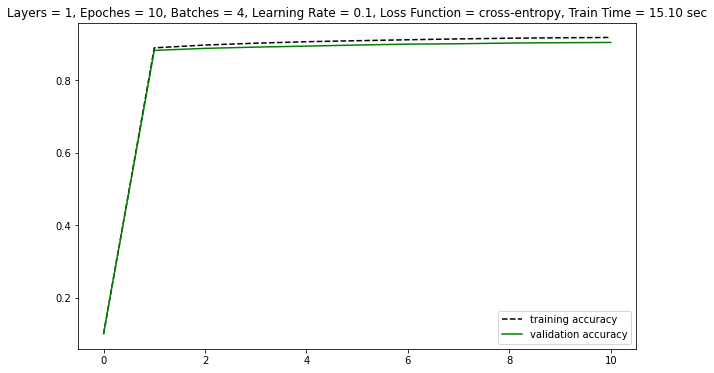

In [23]:
# обучение нейронной сети с одним слоем
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
n_epoch = 10
batch_size = 4
learning_rate = 0.1

trainer = NeuralNetworkTrainer(batch_size, learning_rate)
train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss, 
               title=get_plot_title(len(net.layers), n_epoch, batch_size, learning_rate, loss.func),
               img_name=get_img_name('MNIST', len(net.layers), n_epoch, batch_size, learning_rate, loss.func, 'png'))

Initial train losses=2.3923294292096178, accuracy=0.05390476190476191: 
Initial valid losses=2.395173933387519, accuracy=0.047523809523809524: 
Final train losses=1.0126707837058446, accuracy=0.8908253968253969: 
Final valid losses=1.3683639923493243, accuracy=0.8774285714285714: 


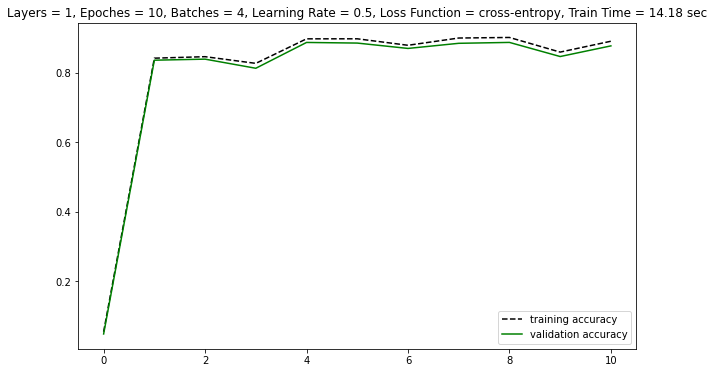

In [24]:
# обучение нейронной сети с одним слоем. Скорость обучения = 0.5
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
n_epoch = 10
batch_size = 4
learning_rate = 0.5

trainer = NeuralNetworkTrainer(batch_size, learning_rate)
train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss, 
               title=get_plot_title(len(net.layers), n_epoch, batch_size, learning_rate, loss.func),
               img_name=get_img_name('MNIST', len(net.layers), n_epoch, batch_size, learning_rate, loss.func, 'png'))

Initial train losses=2.3724308239247134, accuracy=0.08917460317460317: 
Initial valid losses=2.374078667816363, accuracy=0.09038095238095238: 
Final train losses=0.03387498544948286, accuracy=0.989904761904762: 
Final valid losses=0.10805163382427864, accuracy=0.9678095238095238: 


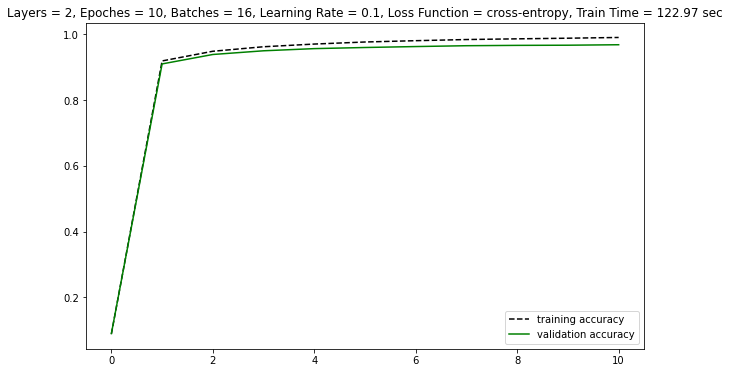

In [27]:
# обучение нейронной сети с 2-мя слоями
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2])
n_epoch = 10
batch_size = 16
learning_rate = 0.1

trainer = NeuralNetworkTrainer(batch_size, learning_rate)
train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss, 
               title=get_plot_title(len(net.layers), n_epoch, batch_size, learning_rate, loss.func),
               img_name=get_img_name('MNIST', len(net.layers), n_epoch, batch_size, learning_rate, loss.func, 'png'))

Initial train losses=2.354492314106588, accuracy=0.09549206349206349: 
Initial valid losses=2.352164598749447, accuracy=0.09571428571428571: 
Final train losses=0.4662610287540973, accuracy=0.9501269841269842: 
Final valid losses=0.6771379221104986, accuracy=0.9416190476190476: 


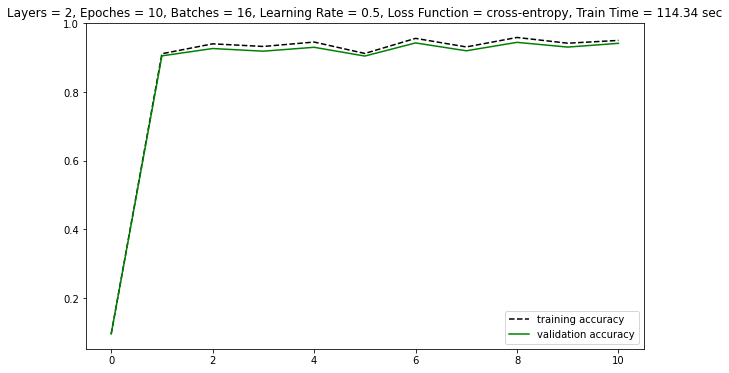

In [28]:
# обучение нейронной сети с 2-мя слоями
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2])
n_epoch = 10
batch_size = 16
learning_rate = 0.5

trainer = NeuralNetworkTrainer(batch_size, learning_rate)
train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss, 
               title=get_plot_title(len(net.layers), n_epoch, batch_size, learning_rate, loss.func),
               img_name=get_img_name('MNIST', len(net.layers), n_epoch, batch_size, learning_rate, loss.func, 'png'))

Initial train losses=2.322628350999345, accuracy=0.1100952380952381: 
Initial valid losses=2.325854724523066, accuracy=0.10933333333333334: 
Final train losses=0.037959551869516495, accuracy=0.9885396825396825: 
Final valid losses=0.10706742080158338, accuracy=0.9678095238095238: 


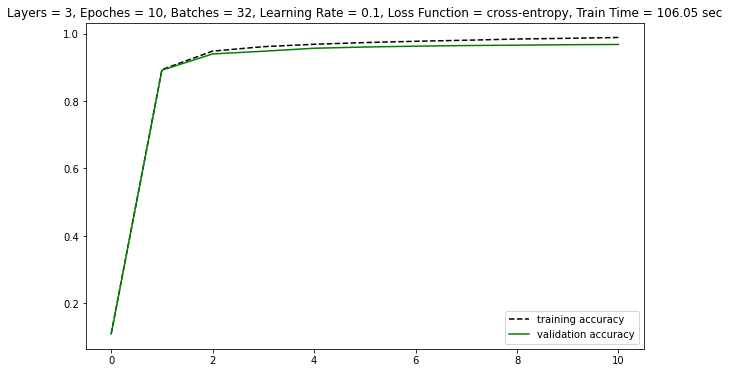

In [29]:
# обучение нейронной сети с 3-мя слоями
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('tanh'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))

net = NeuralNetwork([layer1, layer2, layer3])
n_epoch = 10
batch_size = 32
learning_rate = 0.1

trainer = NeuralNetworkTrainer(batch_size, learning_rate)
train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss, 
               title=get_plot_title(len(net.layers), n_epoch, batch_size, learning_rate, loss.func),
               img_name=get_img_name('MNIST', len(net.layers), n_epoch, batch_size, learning_rate, loss.func, 'png'))

Initial train losses=2.348684423315901, accuracy=0.06942857142857142: 
Initial valid losses=2.351198582116592, accuracy=0.07352380952380952: 
Final train losses=0.01780357047469168, accuracy=0.993904761904762: 
Final valid losses=0.1432740504165219, accuracy=0.9689523809523809: 


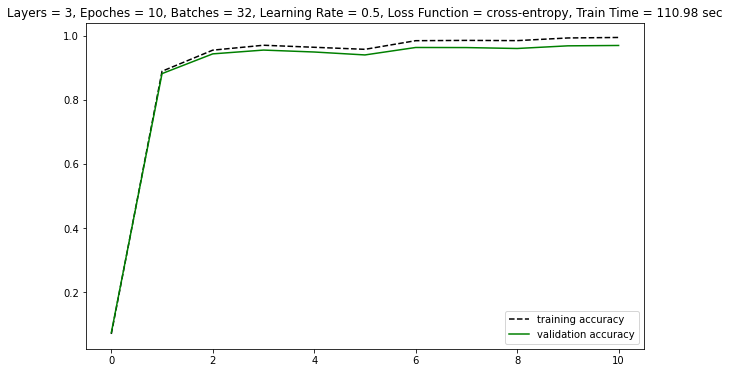

In [30]:
# обучение нейронной сети с 3-мя слоями
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('tanh'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))

net = NeuralNetwork([layer1, layer2, layer3])
n_epoch = 10
batch_size = 32
learning_rate = 0.5

trainer = NeuralNetworkTrainer(batch_size, learning_rate)
train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss, 
               title=get_plot_title(len(net.layers), n_epoch, batch_size, learning_rate, loss.func),
               img_name=get_img_name('MNIST', len(net.layers), n_epoch, batch_size, learning_rate, loss.func, 'png'))

## Fashion MNIST

### Fashion MNIST. Загрузка данных

In [ ]:
!wget -P data/fashion http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -P data/fashion http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -P data/fashion http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -P data/fashion http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

Распаковка данных

In [ ]:
!gzip -d /content/data/fashion/t10k-images-idx3-ubyte.gz
!gzip -d /content/data/fashion/t10k-labels-idx1-ubyte.gz
!gzip -d /content/data/fashion/train-images-idx3-ubyte.gz
!gzip -d /content/data/fashion/train-labels-idx1-ubyte.gz

Установка модуля **idx2numpy** для получения numpy массивов из распакованных данных

In [ ]:
!pip install idx2numpy
import idx2numpy

Разбиваем данные на обучающие и тестовые выборки

In [ ]:
file = 'data/fashion/train-images-idx3-ubyte'
train_images = idx2numpy.convert_from_file(file)

file = 'data/fashion/train-labels-idx1-ubyte'
train_labels = idx2numpy.convert_from_file(file)

file = 'data/fashion/t10k-images-idx3-ubyte'
test_images = idx2numpy.convert_from_file(file)

file = 'data/fashion/t10k-labels-idx1-ubyte'
test_labels = idx2numpy.convert_from_file(file)

### Fashion MNIST. Первоначальный анализ данных, предобработка

In [ ]:
print(f'Размерность матрицы данных train_images: {train_images.shape}')
print(f'Размерность матрицы данных test_images: {test_images.shape}')
print(f'Размерность матрицы данных train_labels: {train_labels.shape}')
print(f'Размерность матрицы данных test_labels: {test_labels.shape}')

print(f'Количество признаков (пикселей): {train_images.shape[1]}')
print(f'Количество объектов (картинок): {train_images.shape[0]}')

# необходимо узнать количество классов на выходе
print(f'Количество разных ответов (классов): {len(np.unique(train_labels))}')

Приводим данные признаков к типу float и масштабируем в диапазон от 0 до 1

In [ ]:
train_images = train_images.astype(float)
train_images = train_images / 255

test_images = test_images.astype(float)
test_images = test_images / 255

Преобразуем данные признаков в двумерные матрицы

In [ ]:
train_images = train_images.reshape(60000, 784)
test_images = test_images.reshape(10000, 784)

print(f'Размерность матрицы данных train_images: {train_images.shape}')
print(f'Размерность матрицы данных test_images: {test_images.shape}')

### Fashion MNIST. Применение нейронных сетей и отображение графика обучения

In [ ]:
loss = LossFunction('cross-entropy')
metrics = NeuralNetworkMetrics()
monitoring = NeuralNetworkMonitoring()

In [ ]:
# обучение нейронной сети с одним слоем
net = NeuralNetwork()
net.add(NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax')))
trainer = NeuralNetworkTrainer(net, batch_size=4, learning_rate=0.01)
res = monitoring.train_and_plot(train_images, train_labels, test_images, test_labels, trainer, 30, loss=loss)

In [ ]:
# обучение нейронной сети с одним слоем. Скорость обучения = 0.5
net = NeuralNetwork()
net.add(NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax')))
trainer = NeuralNetworkTrainer(net, batch_size=4, learning_rate=0.5)
res = monitoring.train_and_plot(train_images, train_labels, test_images, test_labels, trainer, 30, loss=loss)

In [ ]:
# обучение нейронной сети с одним слоем. Скорость обучения = 0.5, количество данных в пакете = 10
net = NeuralNetwork()
net.add(NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax')))
trainer = NeuralNetworkTrainer(net, batch_size=10, learning_rate=0.5)
res = monitoring.train_and_plot(train_images, train_labels, test_images, test_labels, trainer, 30, loss=loss)

In [ ]:
# обучение нейронной сети с 2-мя слоями
net = NeuralNetwork()
net.add(NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh')))
net.add(NeuralNetworkLayer(392, 10, activation_func=ActivationFunction('softmax')))
trainer = NeuralNetworkTrainer(net, batch_size=4, learning_rate=0.01)

print("Initial loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, train_images, train_labels, loss)))
trainer.train_epoch(net, train_images, train_labels, loss)
print("Final loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, train_images, train_labels, loss)))
print("Test loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, test_images, test_labels, loss)))

In [ ]:
print("Initial loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, train_images, train_labels, loss)))
trainer.train_epoch(net, train_images, train_labels, loss)
print("Final loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, train_images, train_labels, loss)))
print("Test loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, test_images, test_labels, loss)))

In [ ]:
# обучение нейронной сети с 3-мя слоями
net = NeuralNetwork()
net.add(NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh')))
net.add(NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('tanh')))
net.add(NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax')))
trainer = NeuralNetworkTrainer(net, batch_size=4, learning_rate=0.01)

print("Initial loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, train_images, train_labels, loss)))
trainer.train_epoch(net, train_images, train_labels, loss)
print("Final loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, train_images, train_labels, loss)))
print("Test loss={}, accuracy={}: ".format(*metrics.get_loss_accurancy(net, test_images, test_labels, loss)))